In [2]:
import pandas as pd

df = pd.read_csv('./data/beer_profile_and_ratings.csv')
def trim_style(style):
    if '-' in style:
        return style.split('-')[0].strip()
    return style

df['Style'] = df['Style'].apply(trim_style)
unique_styles = df['Style'].unique()

df.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3197 non-null   object 
 1   Style              3197 non-null   object 
 2   Brewery            3197 non-null   object 
 3   Beer Name (Full)   3197 non-null   object 
 4   Description        3197 non-null   object 
 5   ABV                3197 non-null   float64
 6   Min IBU            3197 non-null   int64  
 7   Max IBU            3197 non-null   int64  
 8   Astringency        3197 non-null   int64  
 9   Body               3197 non-null   int64  
 10  Alcohol            3197 non-null   int64  
 11  Bitter             3197 non-null   int64  
 12  Sweet              3197 non-null   int64  
 13  Sour               3197 non-null   int64  
 14  Salty              3197 non-null   int64  
 15  Fruits             3197 non-null   int64  
 16  Hoppy              3197 

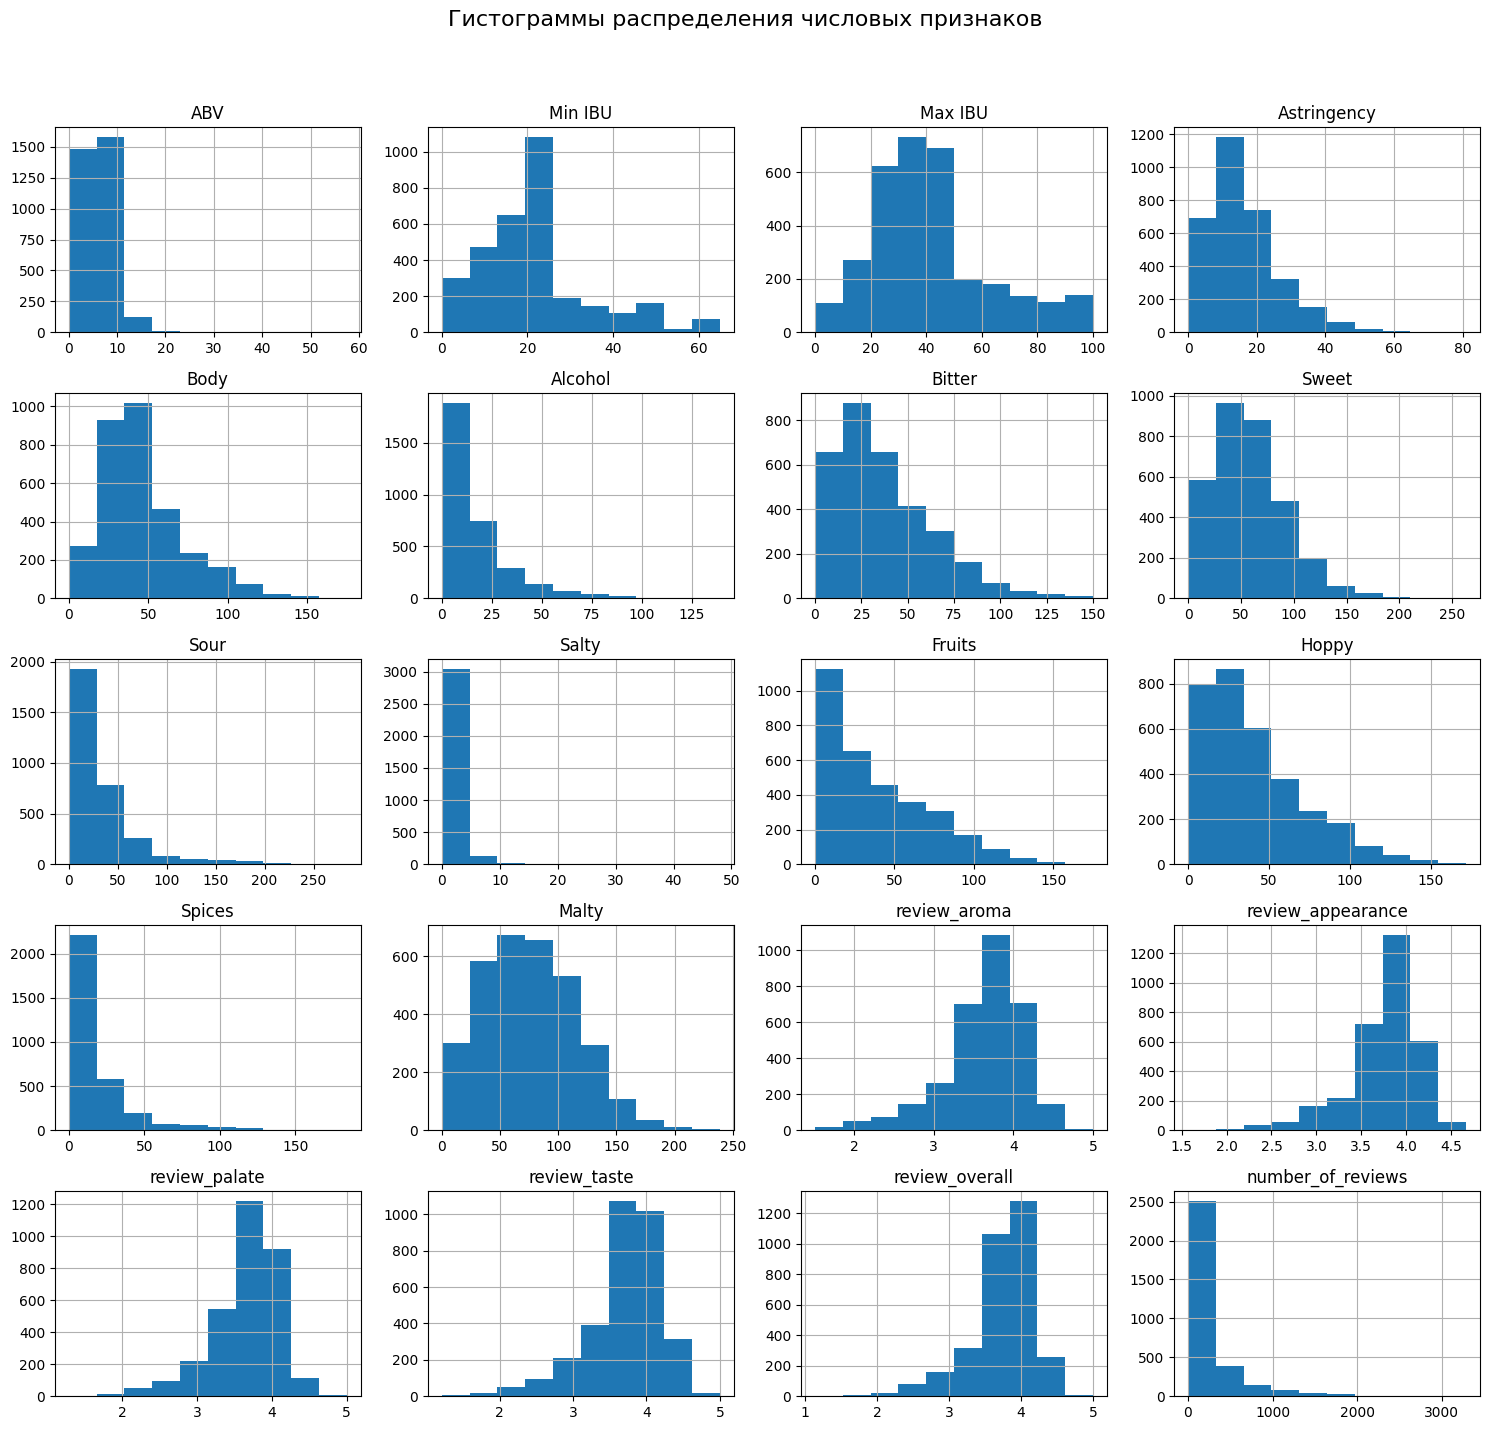

In [4]:
import matplotlib.pyplot as plt

numerical_cols = df.select_dtypes(include=['number']).columns

df[numerical_cols].hist(figsize=(15, 15))
plt.suptitle("Гистограммы распределения числовых признаков", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Анализ выбросов с использованием расстояния Махаланобиса:


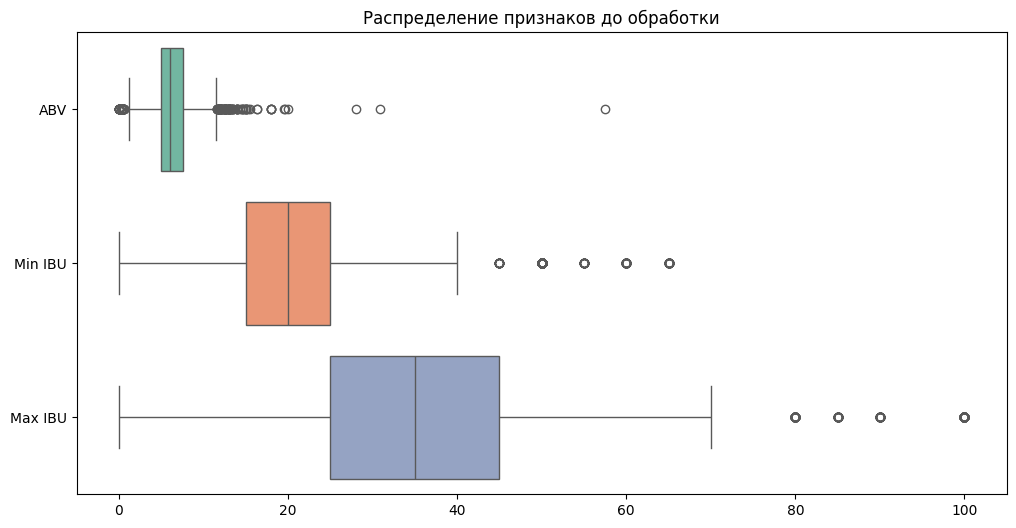


Обнаружено многомерных выбросов: 246 (7.69%)


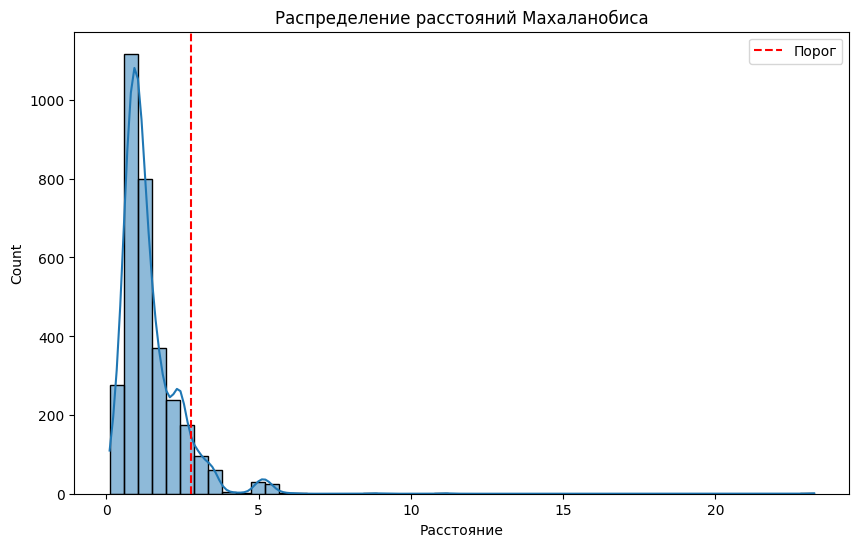


Удалено строк: 246 (7.69%)
Новый размер датасета: (2951, 25)


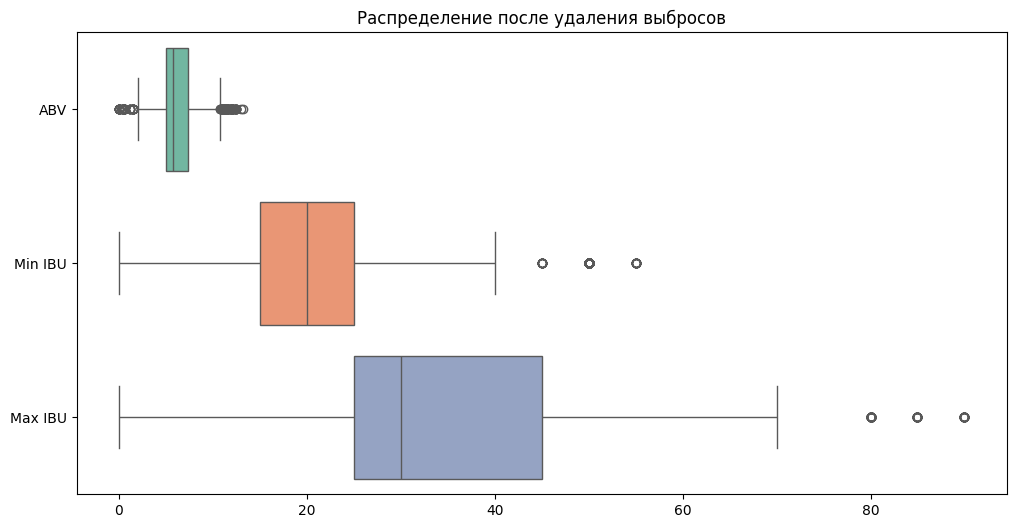

In [5]:
import seaborn as sns
import numpy as np
from scipy.stats import chi2

print("\nАнализ выбросов с использованием расстояния Махаланобиса:")

# Выбираем числовые признаки для анализа
numeric_features = ['ABV', 'Min IBU', 'Max IBU']

# Визуализация распределения до обработки
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_features], orient="h", palette="Set2")
plt.title("Распределение признаков до обработки")
plt.show()

# Функция для вычисления расстояния Махаланобиса
def mahalanobis_dist(df, features):
    X = df[features].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        cov_inv = np.linalg.pinv(cov)  # Используем псевдообратную матрицу если обычная вырождена
    
    deviations = X - mean
    distances = np.sqrt(np.sum(deviations.dot(cov_inv) * deviations, axis=1))
    return distances

# Вычисляем расстояния
distances = mahalanobis_dist(df, numeric_features)

# Определяем порог с использованием хи-квадрат распределения
threshold = chi2.ppf(0.95, df=len(numeric_features))  # 95% доверительный интервал

# Находим индексы выбросов
outliers_mask = distances > np.sqrt(threshold)
outliers = df[outliers_mask]

print(f"\nОбнаружено многомерных выбросов: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

# Визуализация расстояний
plt.figure(figsize=(10, 6))
sns.histplot(distances, bins=50, kde=True)
plt.axvline(x=np.sqrt(threshold), color='r', linestyle='--', label='Порог')
plt.title("Распределение расстояний Махаланобиса")
plt.xlabel("Расстояние")
plt.legend()
plt.show()

# Удаляем выбросы
original_size = len(df)
df_clean = df[~outliers_mask]

print(f"\nУдалено строк: {original_size - len(df_clean)} ({(original_size - len(df_clean))/original_size*100:.2f}%)")
print(f"Новый размер датасета: {df_clean.shape}")

# Визуализация после удаления
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[numeric_features], orient="h", palette="Set2")
plt.title("Распределение после удаления выбросов")
plt.show()

# Обновляем основной датафрейм
df = df_clean.copy()

<Axes: xlabel='count', ylabel='Style'>

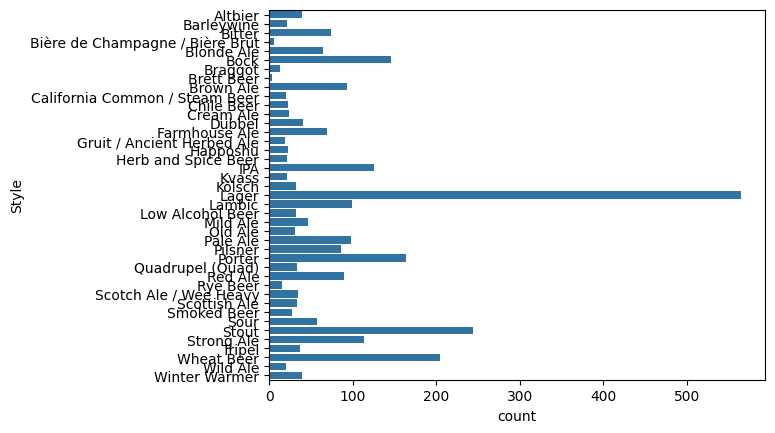

In [6]:
sns.countplot(df['Style'])

<Axes: xlabel='count', ylabel='Style'>

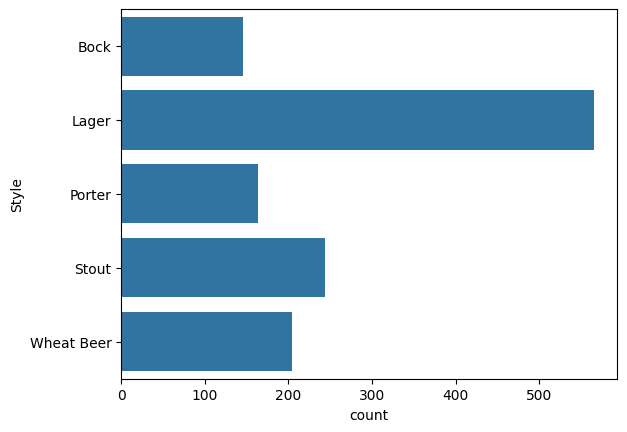

In [7]:
sns.countplot(df[df['Style'].isin(df['Style'].value_counts().head(5).index)]['Style'])

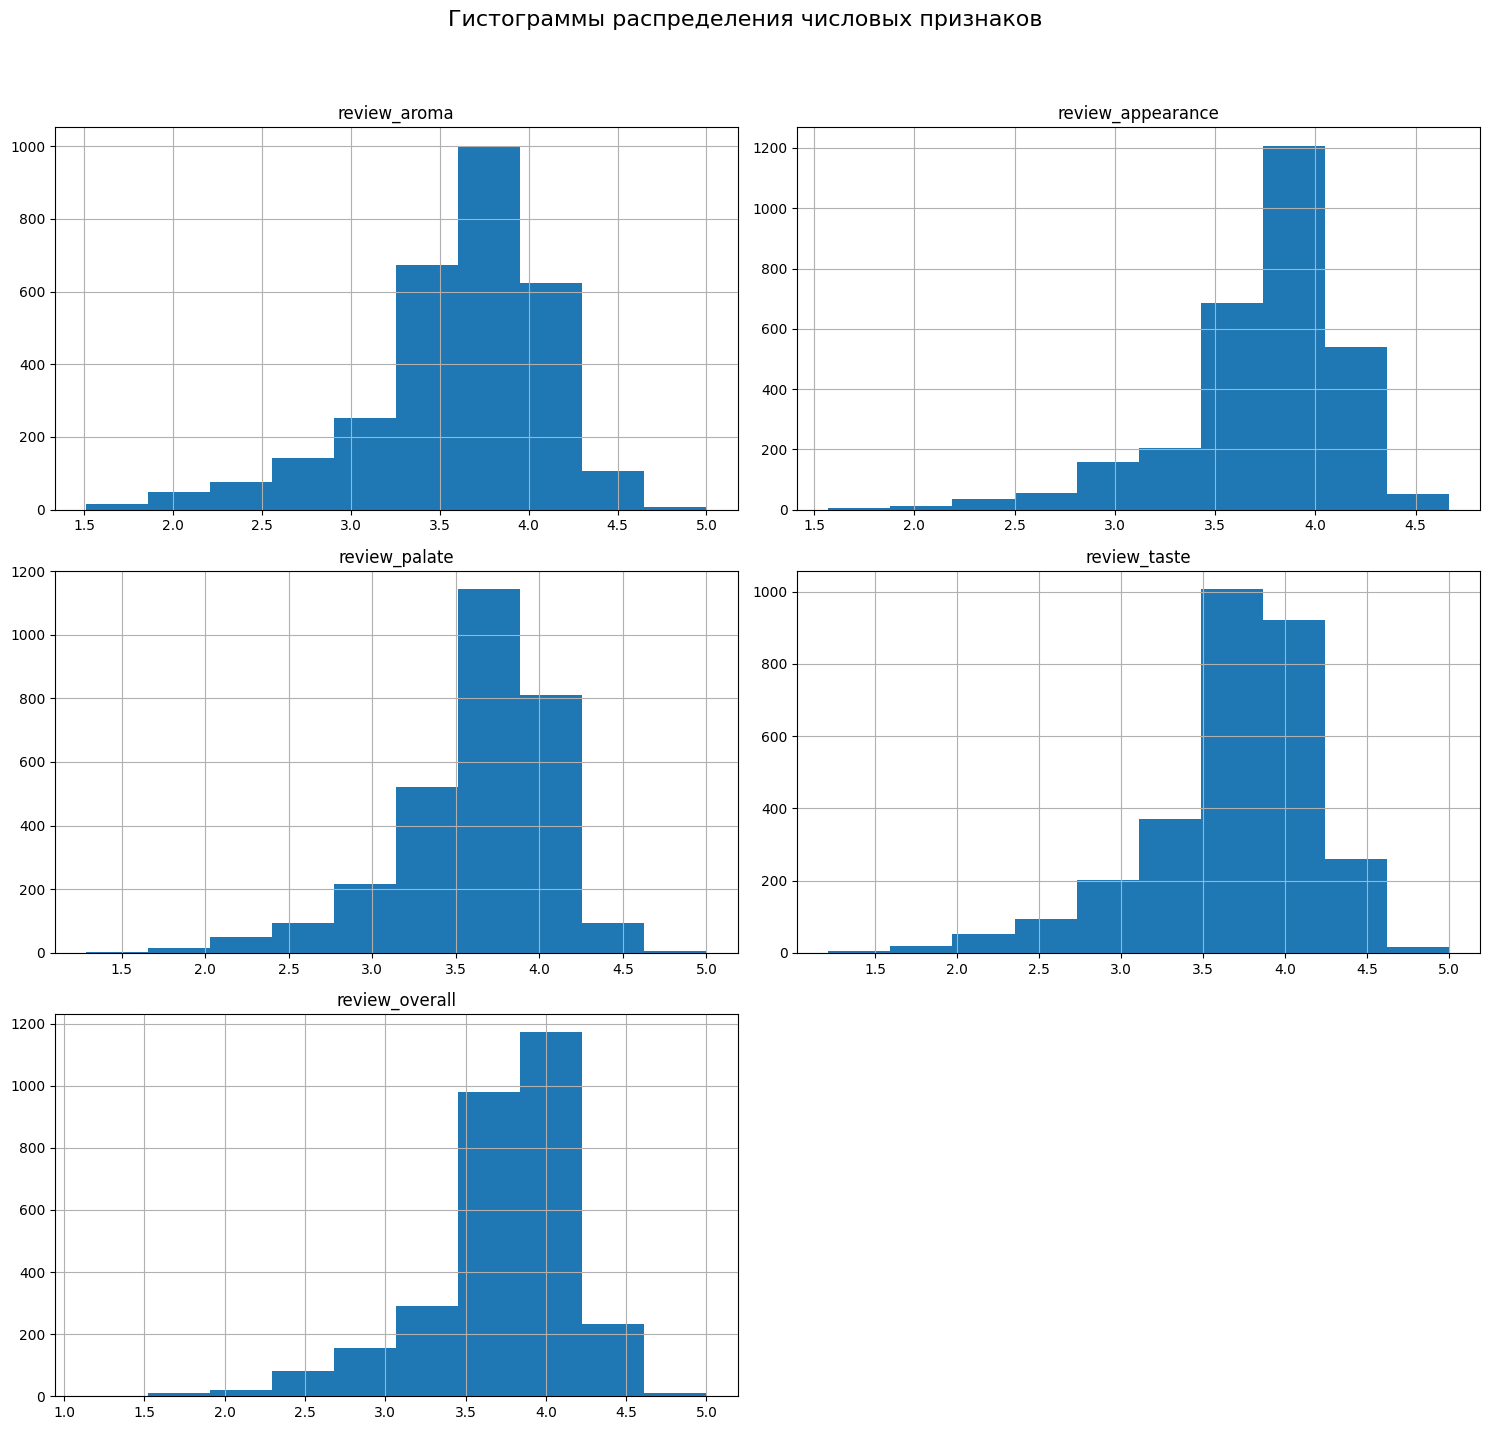

In [ ]:
cols = ['review_aroma',	'review_appearance', 'review_palate', 'review_taste', 'review_overall']

df[cols].hist(figsize=(15, 15))
plt.suptitle("Гистограммы распределения review", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

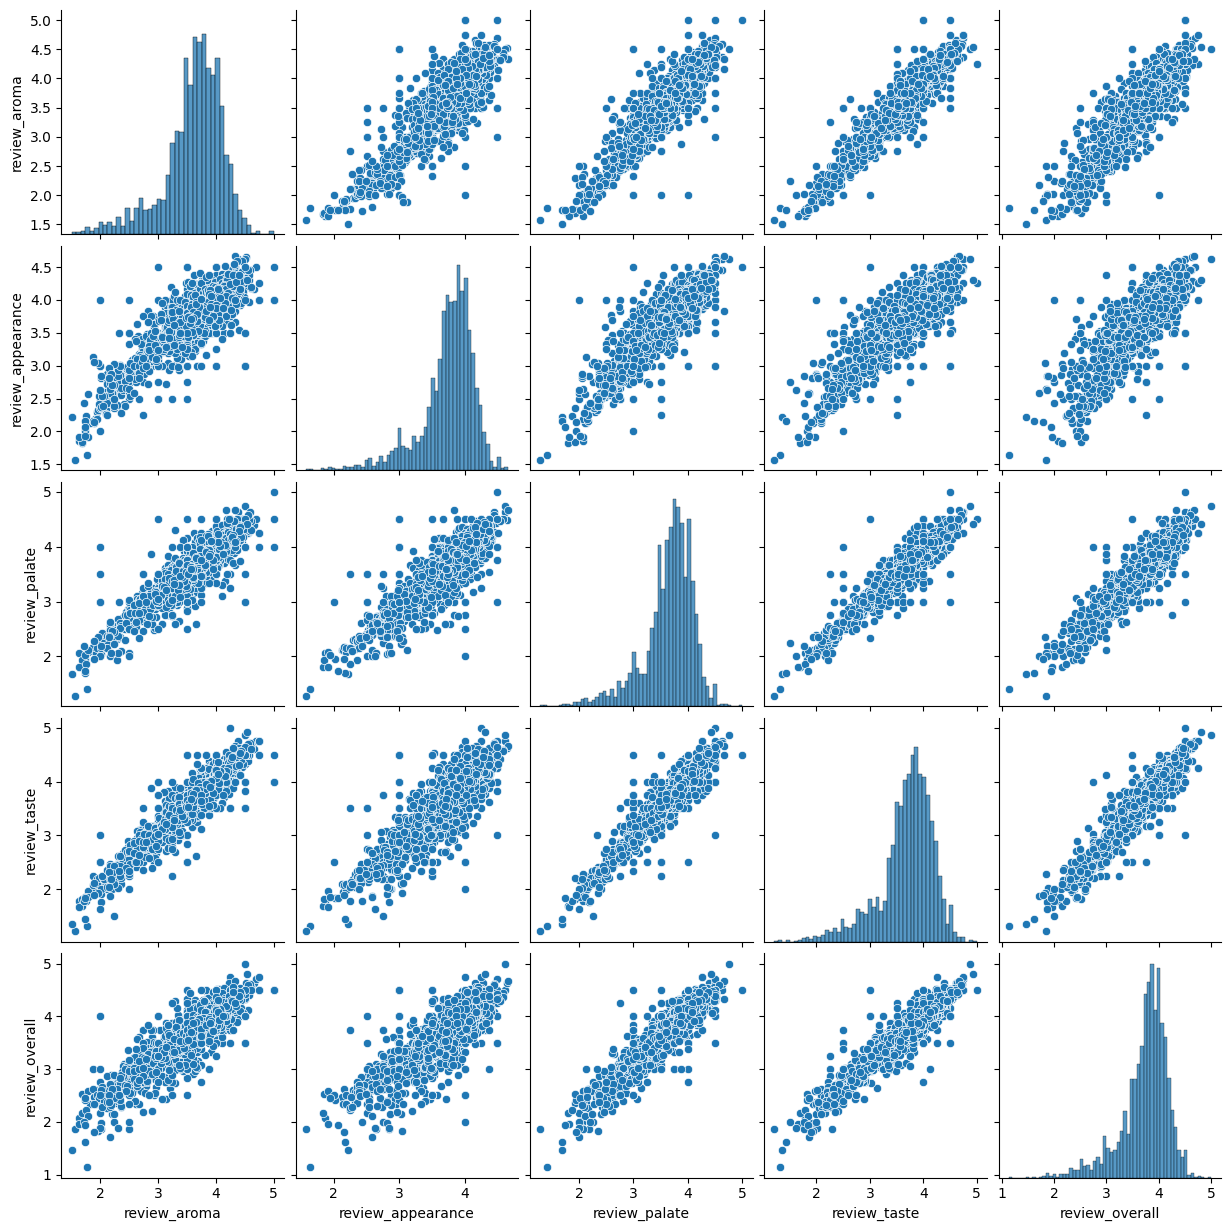

In [9]:
sns.pairplot(df[cols])

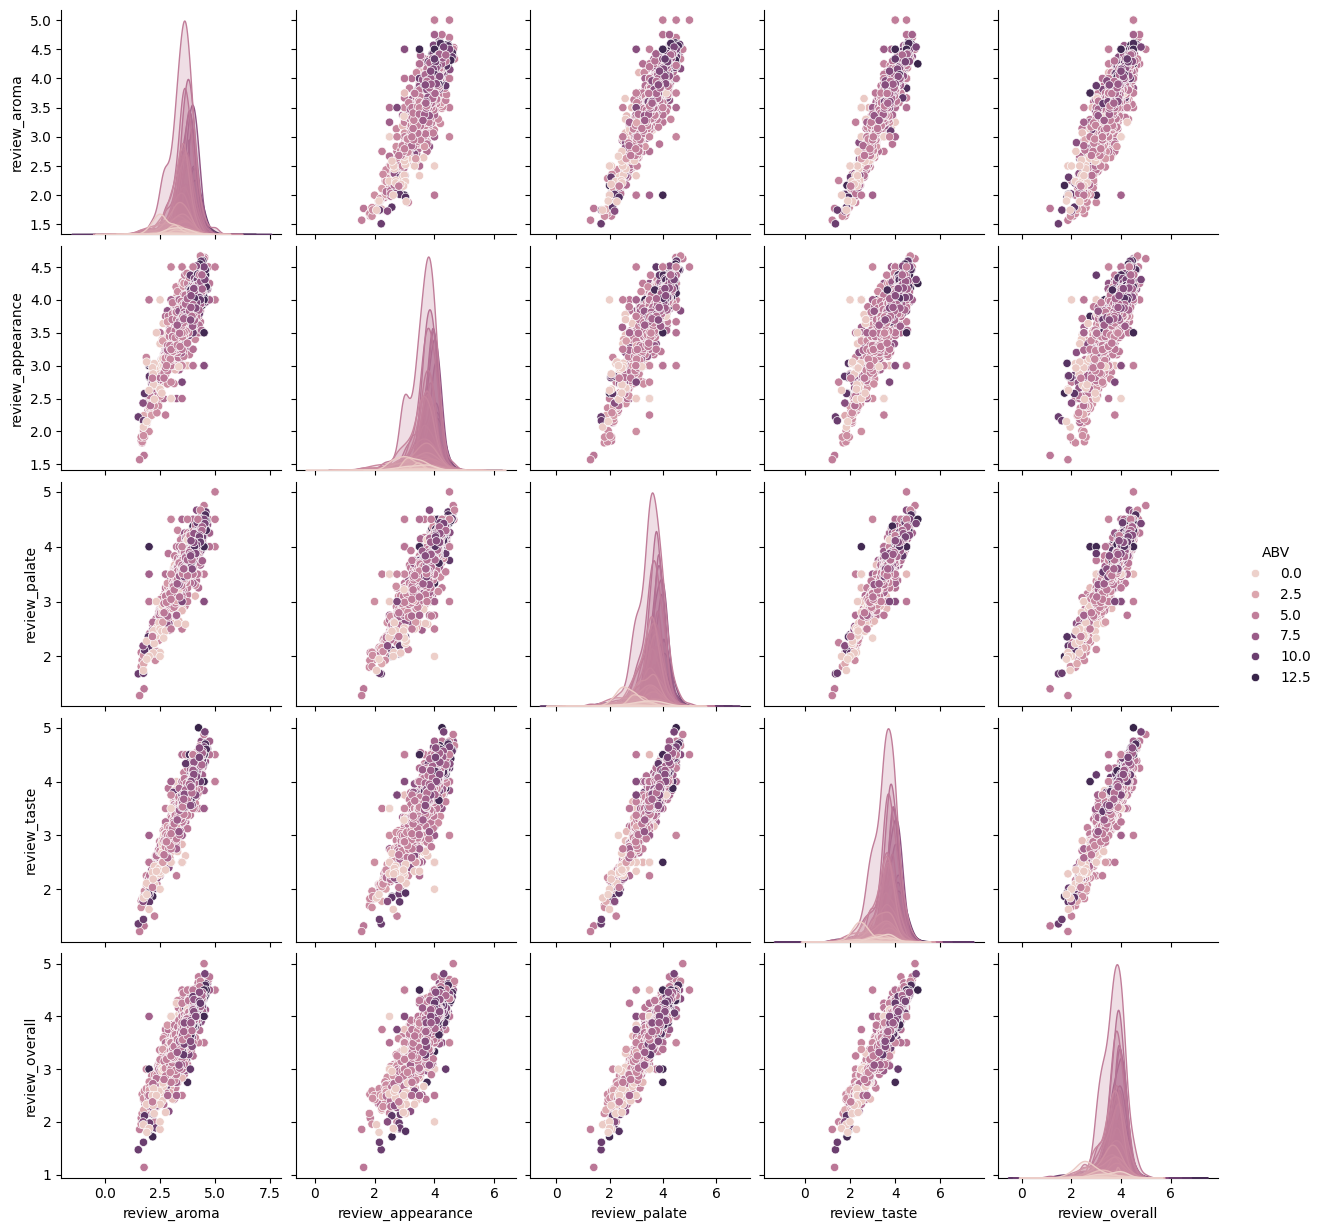

In [10]:
sns.pairplot(df[cols + ['ABV']], hue = 'ABV')

Text(0, 0.5, 'review_overall')

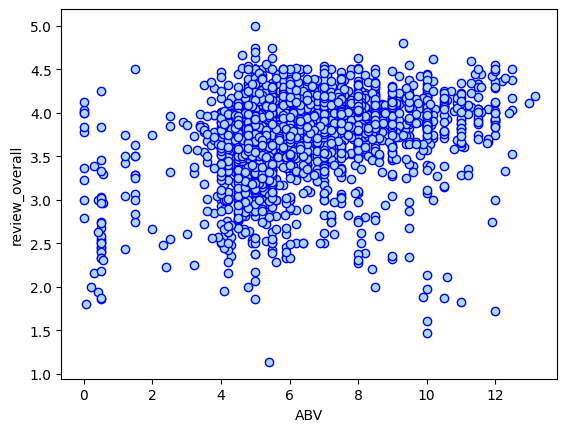

In [11]:
plt.scatter(df['ABV'], df['review_overall'], color='lightblue', edgecolors='blue')
plt.xlabel('ABV')
plt.ylabel('review_overall')

Text(0, 0.5, 'number_of_reviews')

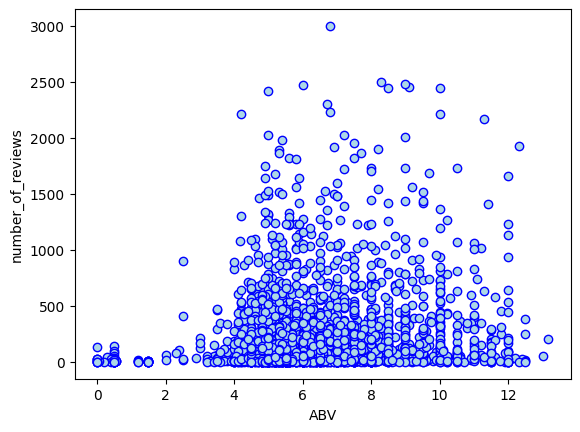

In [12]:
plt.scatter(df['ABV'], df['number_of_reviews'], color='lightblue', edgecolors='blue')
plt.xlabel('ABV')
plt.ylabel('number_of_reviews')

In [13]:
df[numerical_cols].corr()

,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
ABV,1.000000,0.427783,0.510121,-0.137216,0.293726,0.663024,0.087608,0.505287,0.140563,-0.125798,0.330819,-0.052030,0.242864,0.183716,0.432135,0.379019,0.419911,0.405227,0.279086,0.150477
Min IBU,0.427783,1.000000,0.914099,-0.055582,0.363088,0.275585,0.547645,0.214002,-0.104145,-0.049844,0.052869,0.388085,0.014418,0.331803,0.322224,0.377698,0.334286,0.320700,0.284073,0.183386
Max IBU,0.510121,0.914099,1.000000,-0.088284,0.375918,0.339115,0.527201,0.261830,-0.068940,-0.072192,0.096930,0.351312,0.022807,0.326239,0.335231,0.389931,0.340314,0.326118,0.272188,0.179533
Astringency,-0.137216,-0.055582,-0.088284,1.000000,-0.060717,-0.151217,0.111355,-0.004836,0.574722,0.348190,0.386822,0.339847,-0.068399,-0.080871,0.089461,0.082121,0.123205,0.108339,0.168103,-0.044251
Body,0.293726,0.363088,0.375918,-0.060717,1.000000,0.264789,0.560112,0.476219,-0.128529,-0.100938,-0.043494,0.072515,0.191586,0.758341,0.369346,0.426393,0.345185,0.367695,0.314447,0.055018
Alcohol,0.663024,0.275585,0.339115,-0.151217,0.264789,1.000000,0.004432,0.509525,0.057857,-0.088462,0.254532,-0.077789,0.271121,0.252177,0.200856,0.166379,0.171659,0.168498,0.044224,0.044850
Bitter,0.087608,0.547645,0.527201,0.111355,0.560112,0.004432,1.000000,0.106294,-0.156678,0.005818,-0.098107,0.692754,-0.063384,0.585964,0.240611,0.323774,0.246776,0.247458,0.254428,0.096288
Sweet,0.505287,0.214002,0.261830,-0.004836,0.476219,0.509525,0.106294,1.000000,0.260828,-0.134140,0.478375,-0.026572,0.137911,0.484374,0.355956,0.343774,0.314721,0.320906,0.213369,0.048073
Sour,0.140563,-0.104145,-0.068940,0.574722,-0.128529,0.057857,-0.156678,0.260828,1.000000,0.101893,0.818065,0.053198,0.023695,-0.311095,0.299676,0.210718,0.253766,0.254860,0.221300,-0.001911
Salty,-0.125798,-0.049844,-0.072192,0.348190,-0.100938,-0.088462,0.005818,-0.134140,0.101893,1.000000,0.036874,0.182626,-0.026942,-0.029210,-0.084184,-0.079915,-0.033820,-0.053529,-0.007124,-0.022128


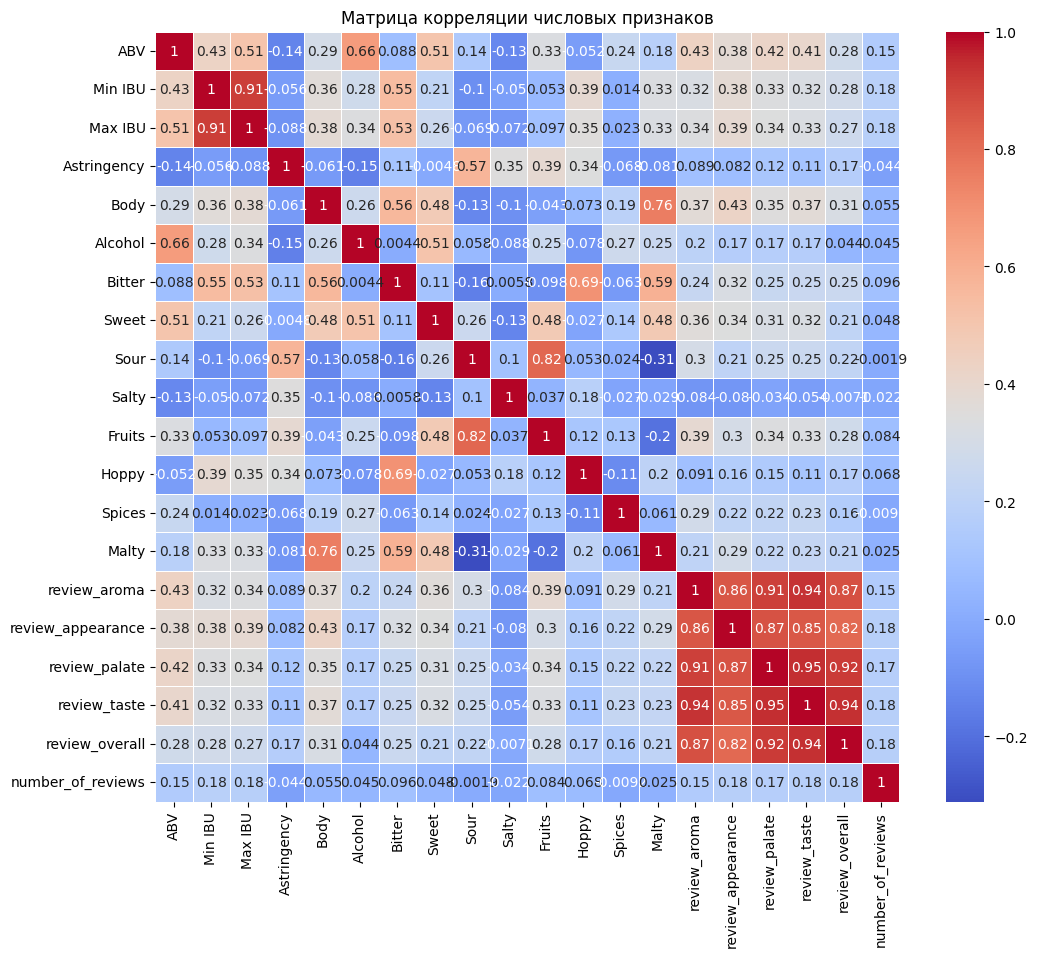

In [14]:
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Матрица корреляции числовых признаков")
plt.show()